In [59]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize


In [138]:
x = np.random.randn(64, 5)
y = np.sin(np.sum(x, axis=1, keepdims=True))
print(x.shape)
print(y.shape)

(64, 5)
(64, 1)


In [140]:
class NonLin_Regressor:
   
    def __init__(self, ind, outd, optr, **kwargs) -> None:

        self.__eps = 1e-10
        self.optr = optr
        self.momentum = None
        self.beta = None
        
        if optr == "momentum":
            if 'momentum' in kwargs:
                self.momentum = kwargs['momentum']
            else:
                self.momentum = 0.9

        elif optr == "Adam":
            if 'beta' in kwargs:
                self.beta = kwargs['beta']
            else:
                self.beta = (0.9, 0.999)
    
        self.w = np.ones((ind, 3))
        self.wg = None
        self.lastwg = None
        self.wl = None
        self.accuwl = None

        self.act = lambda x:np.maximum(0, x)
        self.actg = None

        self.w1 = np.ones((3,outd))
        self.w1g = None
        self.lastw1g = None
        self.w1l = None
        self.accuw1l = None

        self.lossg = None

        

    def forward(self, x:np.ndarray)->np.ndarray:

        self.wg = x.T 
        s1 = x@self.w ##Linear1
        s1 = normalize(s1, axis=0) ##BatchNormalization 1
        
        self.actg =(s1>0).astype(np.float32)
        x1 =  self.act(s1) ## Relu1
        
        self.w1g = x1.T
        x2 = x1@self.w1 ##Linear2
        
        return x2
    
    def train(self, x:np.ndarray, y:np.ndarray, lr=0.01 ,epoch=5)->np.ndarray:
        
        print(self.optr, lr, end=" ")
        if self.optr == "momentum":
            print(self.momentum)

        elif self.optr == "Adam":
            self.wl = 0
            self.w1l = 0
            self.lastwg = 0
            self.lastw1g = 0
            print(self.beta)
        else:
            print()
        

        l = np.ones(epoch)*np.inf
        for e in tqdm(range(epoch)):
            
            yhat = self.forward(x)
            loss = self.mse(yhat=yhat, y = y)
            l[e] = (float(loss))

            g1, g = self.__backward()
            self.__step(lr=lr, g=g, g1=g1)

        return l
    
    def __backward(self)->tuple:
        
        chain = self.lossg
        g1 = (self.w1g@chain)    
        chain = self.actg*(chain@self.w1.T)
        g = self.wg@chain

        return g1, g

    def __step(self, lr=0.01, g1=None, g=None)->None:
        
        gupdate = None
        g1update = None

        match(self.optr):

            case("SGD"):

                gupdate = lr*g
                g1update = lr*g1
        
            case("momentum"):
            
                if self.lastwg is not None:
                    gupdate = lr*g+self.momentum*self.lastwg
                    g1update = lr*g1+self.momentum*self.lastw1g

                else:
                    gupdate = lr*g
                    g1update = lr*g1 
            
                self.lastwg = gupdate
                self.lastw1g = g1update

            case ("Ada"):
            
                if self.accuwl is not None:
                
                    gupdate = lr*g/(self.accuwl+self.__eps)**0.5
                    g1update = lr*g1/(self.accuw1l+self.__eps)**0.5
                    self.accuwl += g**2
                    self.accuw1l += g1**2
            
                else :
                
                    gupdate = lr*g
                    g1update = lr*g1 
            
                    self.accuwl = g**2
                    self.accuw1l = g1**2
        
            case("Adam"):
                
                m = self.beta[0]*self.lastwg + (1-self.beta[0])*g
                v = self.beta[1]*self.wl + (1-self.beta[1])*(g**2)
                gupdate = lr*(m/(1-self.beta[0])
                )/( (v/(1-self.beta[1]))**0.5 + self.__eps)
   

                m1 = self.beta[0]*self.lastw1g + (1-self.beta[0])*g1
                v1 = self.beta[1]*self.w1l + (1-self.beta[1])*(g1**2)
                g1update = lr*(m1/(1-self.beta[0])
                )/( (v1/(1-self.beta[1]))**0.5 + self.__eps)
    
                    
                self.lastwg = m
                self.wl = v

                self.lastw1g = m1
                self.w1l = v1

        self.w -= gupdate
        self.w1 -= g1update
    
    def mse(self, yhat:np.ndarray, y:np.ndarray)->np.float32:
        self.lossg = (yhat-y)/y.shape[0]
        return np.mean(0.5*((yhat-y)**2))
    

SGD 0.01 


100%|██████████| 1000/1000 [00:00<00:00, 13333.45it/s]


momentum 0.01 0.9


100%|██████████| 1000/1000 [00:00<00:00, 16666.55it/s]


Ada 0.01 


100%|██████████| 1000/1000 [00:00<00:00, 15363.08it/s]


Adam 0.01 (0.9, 0.999)


100%|██████████| 1000/1000 [00:00<00:00, 12392.24it/s]


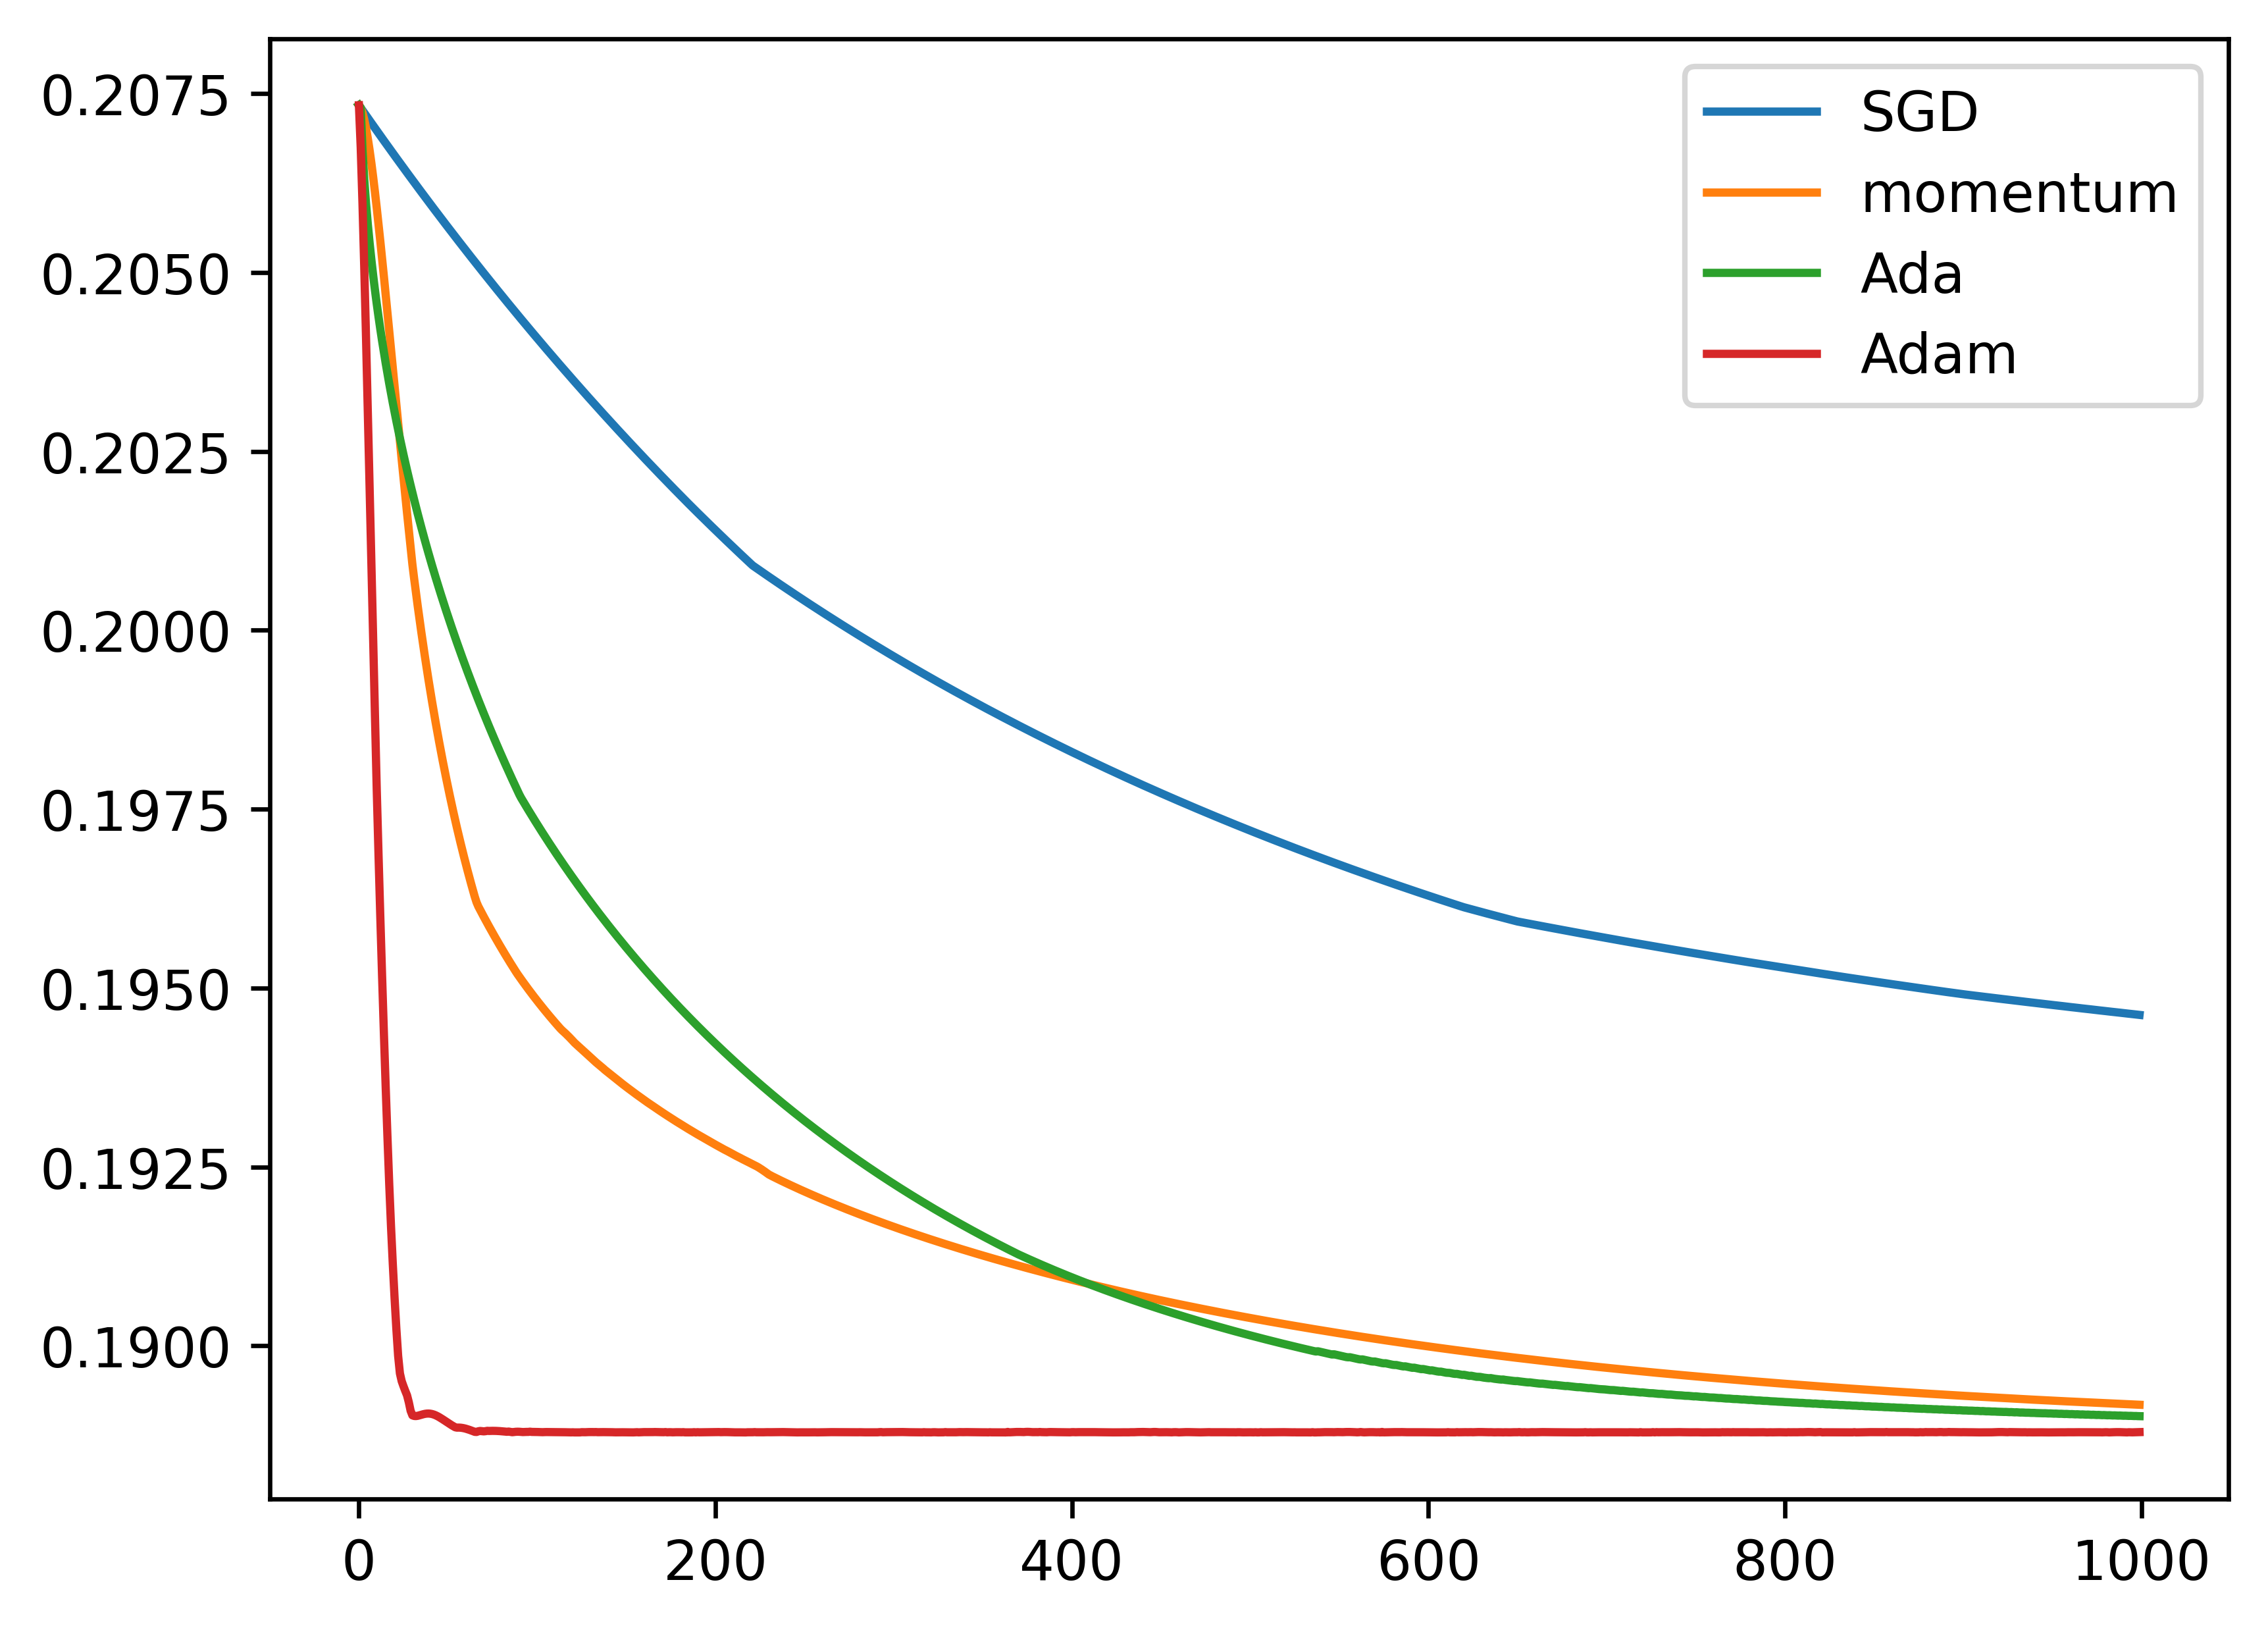

In [144]:
epochs = 1000
lr = 0.01

Rsgd = NonLin_Regressor(ind=x.shape[1], outd=y.shape[1], optr="SGD")
sgdL = Rsgd.train(x=x, y=y, epoch=epochs, lr=lr)

Rmom = NonLin_Regressor(
    ind=x.shape[1], outd=y.shape[1], 
    optr="momentum", momentum=0.9
)
momL = Rmom.train(x=x, y=y, epoch=epochs, lr=lr)

Rada = NonLin_Regressor(ind=x.shape[1], outd=y.shape[1], optr="Ada")
adaL = Rada.train(x=x, y=y, epoch=epochs, lr=lr)

Radam = NonLin_Regressor(ind=x.shape[1], outd=y.shape[1], optr="Adam")
adamL = Radam.train(x=x, y=y, epoch=epochs, lr=lr)


e = np.arange(epochs)
plt.figure(dpi=600)
plt.plot(e, sgdL, label="SGD")
plt.plot(e, momL, label="momentum")
plt.plot(e, adaL, label="Ada")
plt.plot(e, adamL, label="Adam")
plt.legend()
plt.show()
